### 업무 수행자: 최정윤

In [1]:
import os
import sys

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
name1 = 'tests'

In [4]:
base_path = os.path.abspath('.')
data_path = os.path.join(base_path, 'data')

# 1. Read Data

- eindex, eindex1 가격 차이 남

In [5]:
eindex_path = os.path.join(data_path, 'totindex.csv')
eindex1_path = os.path.join(data_path, 'priceindex.csv')
efuture_path = os.path.join(data_path, 'FutGenratio1.csv')

In [6]:
total_ret_idx = pd.read_csv(eindex_path, header=0, index_col=0, parse_dates=True)
total_ret = total_ret_idx.pct_change(1)
prc_idx = pd.read_csv(eindex1_path, header=0, index_col=0, parse_dates=True)
prc_ret = prc_idx.pct_change(1)
fut_idx = pd.read_csv(efuture_path, header=0, index_col=0, parse_dates=True)
fut_idx.index = pd.to_datetime(fut_idx.index, unit='D', origin=pd.Timestamp('1899-12-30'))
fut_ret = fut_idx.pct_change(1)

# 만약에 eindex에 빈 정보가 있으면 eindex1으로 대체
no_data_dates = total_ret[(total_ret.isnull().sum(axis=1) > 0).values].index
total_ret.loc[no_data_dates] = prc_ret.loc[no_data_dates]

# 2007년까지는 eindex 2008년부터는 future 사용
ERet = pd.concat([total_ret.loc[:'2007-12-31'], fut_ret.loc['2008-01-01':]], axis=0)
ERet.fillna(0, inplace=True)
Eindex = (1. + ERet).cumprod()

# 2. Parameter Setting

In [38]:
RBP = 3
CSNUM = 0.35
CSpos = 0

# param setting part
RB1 = RBP
RB2 = RBP

RET = ERet.copy()
RETfinal = RET.copy()
index = Eindex.copy()

CSdesign = "notional"

In [39]:
RETfinal = RET.copy()

# 3. Calculate Signal

<strong>Equity Quality 전략</strong>
- ROA, ICR 상승률 높은 것 Long 및 ROA, ICR 상승률 낮은 것 Short

In [61]:
for i in range(2):
    if i == 0:
        RET = ERet.loc[:, ERet.columns[:10]]
    else:
        RET = ERet.loc[:, ERet.columns[10:]]

    index = Eindex.loc[:, RET.columns]

    # 1. Load Data
    roa_path = os.path.join(data_path, 'ROA.csv')
    roa = pd.read_csv(roa_path, header=0, index_col=0, parse_dates=True)
    roa = roa[index.columns]

    icr_path = os.path.join(data_path, 'ICR.csv')
    icr = pd.read_csv(icr_path, header=0, index_col=0, parse_dates=True)
    icr = icr[index.columns]

    # 2. Parameter Setting
    minobs1 = 12
    minobs = 60
    longlen = 6
    shortlen = 0
    Expanding = 0

    nopos = 0.4
    lag = 1

    CS = CSNUM

    # Signal1
    # 3. RV
    RV1 = roa
    RV = (RV1 - RV1.shift(lag)).iloc[lag:]
    TD = RV

    # 4. rank
    pctrank = lambda x: pd.Series(x).rank(pct=True).iloc[-1]
    RVrank = RV.expanding().apply(pctrank, raw=True) # it takes some time
    RVrank = RVrank.iloc[minobs1-1:,]

    # 5. trade
    truecount = (RVrank.notnull().sum(axis=1) * CS).apply(round)
    tiebreaker = RVrank.rolling(5).mean().fillna(0) * 0.0000001

    # 1. Cross sectional
    CSRV = (RVrank + tiebreaker).rank(axis=1, method='first') # Short
    CSRV1 = (-1 * RVrank -1 * tiebreaker).rank(axis=1, method='first') # Long

    CSRVpos = CSRV* 0
    CSRVpos[CSRV.apply(lambda x: x <= truecount, axis=0)] = -1
    CSRVpos[CSRV1.apply(lambda x: x <= truecount, axis=0)] = 1

    CSRV = CSRVpos
    CSRV.fillna(0, inplace=True)
    CSRVone = CSRV

    # 2. Time Series
    TSRV1 = RVrank * 0
    TSRV1[RVrank > nopos + (1-nopos)/2] = 1 # Long
    TSRV1[RVrank < (1-nopos)/2] = -1 # Short

    # 2. Signal2
    RV1 = icr
    RV = (RV1 - RV1.shift(lag)).iloc[lag:]
    TD = RV

    # 1. rank
    pctrank = lambda x: pd.Series(x).rank(pct=True).iloc[-1]
    RVrank = RV.expanding().apply(pctrank, raw=True) # it takes some time
    RVrank = RVrank.iloc[minobs1-1:,]

    # 2. trade
    truecount = (RVrank.notnull().sum(axis=1) * CS).apply(round)
    tiebreaker = RVrank.rolling(5).mean().fillna(0) * 0.0000001

    # 1. Cross sectional
    CSRV = (RVrank + tiebreaker).rank(axis=1, method='first') # Short
    CSRV1 = (-1 * RVrank -1 * tiebreaker).rank(axis=1, method='first') # Long

    CSRVpos = CSRV * 0
    CSRVpos[CSRV.apply(lambda x: x <= truecount, axis=0)] = -1
    CSRVpos[CSRV1.apply(lambda x: x <= truecount, axis=0)] = 1

    CSRV = CSRVpos
    CSRV.fillna(0, inplace=True)
    CSRVtwo = CSRV

    # 2. Time Series
    TSRV2 = RVrank.fillna(0) * 0
    TSRV2[RVrank > nopos + (1-nopos)/2] = 1 # Long
    TSRV2[RVrank < (1-nopos)/2] = -1 # Short

    TSRV = (2*TSRV1 + TSRV2)/3
    CSRV = (CSRVone + 2*CSRVtwo)/3

    if i == 0:
        TSRVrun1 = TSRV
        CSRVrun1 = CSRV
    else:
        TSRVrun2 = TSRV
        CSRVrun2 = CSRV

# 4. Combine Result

In [67]:
TSRV = pd.concat([TSRVrun1, TSRVrun2], axis=1)
CSRV = pd.concat([CSRVrun1, CSRVrun2], axis=1)

In [68]:
TSRV = TSRV[ERet.columns]
CSRV = CSRV[ERet.columns]

In [70]:
# Align dates with Return DataFrame
TSRV = TSRV.loc[RET.index].fillna(method='ffill').dropna(how='all')
CSRV = CSRV.loc[RET.index].fillna(method='ffill').dropna(how='all')

# Align dates with each other
if TSRV.index[0] > CSRV.index[0]:
    CSRV = CSRV.loc[TSRV.index[0]:]
else:
    TSRV = TSRV.loc[CSRV.index[0]:]

c:\programdata\anaconda3\envs\project\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
c:\programdata\anaconda3\envs\project\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


# 5. Backtest

In [73]:
def ex_ante_vol(df_ret, todate, weights, lookback=130, shrink_corr=0.9):
    '''
    Args:
        df_ret: pandas DataFrame of returns
        todate: date to calculate ex ante vol
        weights: weight of strategy before ex ante vol control
        lookback: number of days to consider for calculating cov
        shrink_corr: weight to shrink correlation
    '''
    # setting data range
    todate_loc = df_ret.index.get_loc(todate)
    if todate_loc > lookback:
        fromdate_loc = todate_loc - lookback
    else:
        fromdate_loc = 0
    
    # calculate corr apply shrinkage
    corr = df_ret.iloc[fromdate_loc:todate_loc].corr()
    corr = corr * shrink_corr + np.diag(np.ones(len(df_ret.columns))) * (1.- shrink_corr)
    # calculate cov
    std = df_ret.iloc[fromdate_loc:todate_loc].std()
    cov = pd.DataFrame(np.diag(std).dot(corr).dot(np.diag(std)), index=RET.columns, columns=RET.columns)
    # calculate ex ante vol
    return np.sqrt(weights.dot(cov).dot(weights)) * np.sqrt(260)

In [74]:
class GRP_bt:
    '''
    '''
    def __init__(self, CSLS, RET, RB, min_vol, freq):
        '''
        '''
        self.CSLS = CSLS  # Cross Sectional Exposure Type. 'vol' means volatility allocation. 'notional' means notional. 
        self.RET = RET  # 
        self.RB = RB
        
        self.Assetvol = 0.02 # vol control parameter for individual assets
        self.Strategyvol = 0.02 # vol control parameter for whole strategy
        self.factorvol = 0.02
        self.factorsd = 260 # lookback period for calcualting factorvol
        self.assetsd = 90 # lookback period for calculating Assetvol
        self.statsd = 90 # lookback period for calcualting Strategyvol

        self.volband = 0.05 # if controled vol is within volband, do not change vol
        self.min_vol = min_vol # vol floor 0.04 for ir strategy, 0.15 for all otheres
        self.freq = freq # strategy frequency setting. it only applys to Cross Sectional backtesting now.
        
        # Calculating volatility for assets
        std = (self.RET.rolling(window=self.assetsd).std() * np.sqrt(260)).iloc[self.assetsd:]
        # Adjust calculated asset volatility
        self.std_adj = self.adjust_by_volband(std, self.volband, min_vol=self.min_vol)

    def adjust_by_volband(self, df_vol, volband, min_vol=None):
        for i in range(1, len(df_vol.index)):
            if df_vol.iloc[i].name.weekday() == self.RB:
                for c in range(len(df_vol.columns)):
                    # case1. if new std is null
                    if pd.isnull(df_vol.iloc[i, c]):
                        df_vol.iloc[i, c] = df_vol.iloc[i-1, c]
                    # case2. if new std within volband
                    if abs(df_vol.iloc[i, c] - df_vol.iloc[i-1, c]) < volband * df_vol.iloc[i-1, c] :
                        df_vol.iloc[i, c] = df_vol.iloc[i-1, c]
            else:
                df_vol.iloc[i] = df_vol.iloc[i-1]
        if min_vol is not None:
            df_vol[df_vol < min_vol] = min_vol

        return df_vol
    
    def ts_vol_control_backtest(self, TSRV):
        # Time Series 
        VCweight = self.Assetvol / self.std_adj
        VCTSpos = (VCweight * TSRV).loc[TSRV.index[0]:] # Vol Control Time Series Position
        VCTSpos.replace([np.inf, -np.inf], np.nan, inplace=True)
        
        # Strategy level vol control
        # return of VC strategy
        Strategy = ((self.RET * VCTSpos.shift(1)).sum(axis=1)).loc[TSRV.index[0]:]
        # using average of expanding & moving window strategy risk
        Strategyrisk_expanding = (Strategy.expanding(min_periods=self.statsd).std()*np.sqrt(260)).iloc[self.statsd:]
        Strategyrisk_rolling = (Strategy.rolling(window=self.statsd).std()*np.sqrt(260)).iloc[self.statsd:]
        Strategyrisk = (Strategyrisk_expanding + Strategyrisk_rolling) / 2.
        # volband adjustment
        bufrisk = self.adjust_by_volband(Strategyrisk.copy().to_frame(), self.volband)
        # apply strategy level vol control to position
        statlev = self.Strategyvol / bufrisk.iloc[:,0]
        self.TSposition = VCTSpos.multiply(statlev, axis='index').iloc[self.statsd:]
        self.TSposition.replace([np.inf, -np.inf], np.nan, inplace=True)
        self.TSposition.fillna(0, inplace=True)
        
        # calculate daily strategy return
        self.TSStrategy = (self.RET * self.TSposition.shift(1)).sum(axis=1).loc[TSRV.index[0]:]
        self.TSStrategylag = (self.RET * self.TSposition.shift(2)).sum(axis=1).loc[TSRV.index[0]:]
    
    def cs_vol_control_backtest(self, CSRV):
        if self.CSLS == 'vol':
            CSRV = (CSRV * self.Assetvol / self.std_adj).loc[CSRV.index[0]:]
        #elif self.CSLS != 'notional': # raise error
            
        # Calculating Ex-ante Vol and adjust to target vol which specified by 'Strategyvol'
        if self.freq == 'week':
            for i in range(len(CSRV.index)):
                if CSRV.iloc[i].name.weekday() == self.RB:
                    CSRV.iloc[i] = CSRV.iloc[i] * self.Strategyvol / ex_ante_vol(self.RET, CSRV.iloc[i].name, CSRV.iloc[i])
                else:
                    CSRV.iloc[i] = CSRV.iloc[i-1]
        elif self.freq == 'month':
            for i in range(len(CSRV.index)):
                if CSRV.iloc[i].name.month != CSRV.iloc[i-1].name.month:
                    CSRV.iloc[i] = CSRV.iloc[i] * self.Strategyvol / ex_ante_vol(self.RET, CSRV.iloc[i].name, CSRV.iloc[i])
                else:
                    CSRV.iloc[i] = CSRV.iloc[i-1]
        #else: # raise error
            
        # Strategy level vol control
        # return of VC strategy
        CSraw = (self.RET * CSRV.shift(1)).dropna(how='all').sum(axis=1)
        CSrisk = (CSraw.rolling(window=self.statsd).std()*np.sqrt(260)).iloc[self.statsd:]
        
        # volband adjustment
        cs_bufrisk = self.adjust_by_volband(CSrisk.to_frame(), self.volband)
        # apply strategy level vol control to position
        cs_statlev = self.Strategyvol / cs_bufrisk.iloc[:,0]
        self.CSposition = CSRV.multiply(cs_statlev, axis='index').iloc[self.statsd:]
        self.CSposition.replace([np.inf, -np.inf], np.nan, inplace=True)
        self.CSposition.fillna(0, inplace=True)
        
        # calculate daily strategy return
        self.CSStrategy = (self.RET * self.CSposition.shift(1)).sum(axis=1).loc[CSRV.index[0]:]
        self.CSStrategylag = (self.RET * self.CSposition.shift(2)).sum(axis=1).loc[CSRV.index[0]:]

### TS

In [75]:
RET = RETfinal

In [76]:
GRP_bt_test = GRP_bt(CSLS=CSdesign, RET=RET, RB=RBP, min_vol=0.15, freq='month')
GRP_bt_test.ts_vol_control_backtest(TSRV)

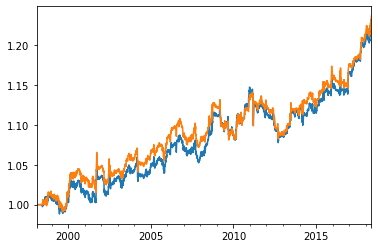

In [77]:
(1. + GRP_bt_test.TSStrategy).cumprod().plot()
(1. + GRP_bt_test.TSStrategylag).cumprod().plot()

### CS

In [78]:
GRP_bt_test.cs_vol_control_backtest(CSRV)

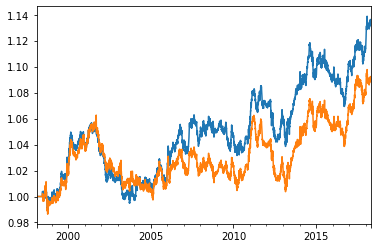

In [79]:
(1. + GRP_bt_test.CSStrategy).cumprod().plot()
(1. + GRP_bt_test.CSStrategylag).cumprod().plot()